# Sharpe Ratio

In [4]:
import pandas as pd
import yfinance as yf  # Yahoo Finance

from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In this notebook, we will be attempting to predict the sharpe ratio of several commodity futures. All data in this notebook was collected via Yahoo Finance's API. We will predict the sharpe ratio using the futures with the nearest expiration dates, specifically:

1. Corn Futures (ZC=F), daily close values.
2. Soybean Futures (ZS=F), daily close values.
3. Wheat Futures (ZW=F), daily close values.
4. Oats Futures (ZO=F), daily close values.
5. Rice Futures (ZR=F), daily close values.

We start by retrieving information of the risk-free stock, which in this case we chose to be ^IRX (13 WEEK USA TREASURY BILL). All values used will be CLOSE values. The data collected is of the last 10 years.

In [5]:
rf = yf.Ticker('^IRX')
rf = rf.history(period='10y')
rf['Datetime'] = rf.index
rf.reset_index(drop=True, inplace=True)
rf['Date'] = rf['Datetime'].dt.date
rf['Return'] = rf['Close'].pct_change()

Next, we retrieve data from the last 10 years of all commodity prices, those listed above.

In [6]:
products = {'Corn': 'ZC', 
            'Soybean': 'ZS', 
            'Wheat': 'ZW', 
            'Oats': 'ZO',
            'Rice': 'ZR',}

df_futures = pd.DataFrame()

for product in products:
    value = f'{products[product]}=F'
    futures = yf.Ticker(value)
    futures = futures.history(period='10y')
    df_futures[product] = futures['Close']


df_futures['Datetime'] = df_futures.index
df_futures.reset_index(drop=True, inplace=True)
df_futures['Date'] = df_futures['Datetime'].dt.date

In [7]:
df_futures = df_futures.merge(rf[['Date', 'Return']], on='Date', how='left')
df_futures.rename(columns={'Return': 'rf'}, inplace=True)
df_futures.dropna(inplace=True)

In [8]:
# compute sharp ratio for each product in each year
sharp_ratios = {}

for product in products:
    df_futures[f'{product}_return'] = df_futures[product].pct_change()
    df_futures[f'{product}_excess_return'] = df_futures[f'{product}_return'] - df_futures['rf']
    # compute sharp ratio for each year
    sharp_ratios[product] = {}
    for year in range(2015, 2024):  # only data with full years
        df_year = df_futures[df_futures['Datetime'].dt.year == year]
        sharp_ratio = df_year[f'{product}_excess_return'].mean() / df_year[f'{product}_excess_return'].std()
        annualized_sharp_ratio = sharp_ratio * (252 ** 0.5)
        sharp_ratios[product][year] = annualized_sharp_ratio

In [9]:
print('Yearly Sharpe Ratio For Each Product (Compared to Risk Free Rate based on 3 month treasury bill)')
for product in sharp_ratios:
    print(product)
    for year in sharp_ratios[product]:
        print(f'{year}: {sharp_ratios[product][year]}')
    print('\n')

Yearly Sharpe Ratio For Each Product (Compared to Risk Free Rate based on 3 month treasury bill)
Corn
2015: -3.516223306507166
2016: -1.5182527232324277
2017: -2.5845775702995333
2018: -2.009376223124832
2019: 1.5892028677142187
2020: 0.8983246753264268
2021: -1.6436277598048479
2022: -4.089507339183072
2023: -1.4898806199016659


Soybean
2015: -3.5201592379326403
2016: -1.4218516399728134
2017: -2.8824237500066787
2018: -2.582910395311469
2019: 2.0762783979388844
2020: 0.907946186479025
2021: -1.6988795737068176
2022: -4.132094534726096
2023: -1.425328178618341


Wheat
2015: -3.5275869118301646
2016: -1.5826164412083972
2017: -2.319385587736925
2018: -1.0216839535654743
2019: 1.6805147756263659
2020: 0.888736476398857
2021: -1.6542403842362274
2022: -3.912465303827852
2023: -0.9546497207081237


Oats
2015: -3.5265680509925614
2016: -1.4102311447449825
2017: -1.9893911971200078
2018: -1.074511413146682
2019: 1.4210761014474496
2020: 0.8998392008061844
2021: -1.5736345159908545
2022: -4

Now, we will compute the sharpe ratio on a bi-weekly basis, making it so that we will have more sharpe ratios that we can train a model on.

In [16]:
WINDOW_SIZE = 14

normalized_sharpe_ratios = {}

for product in products:
    df_futures[f'{product}_return'] = df_futures[product].pct_change()
    df_futures[f'{product}_excess_return'] = df_futures[f'{product}_return'] - df_futures['rf']
    rolling_mean = df_futures[f'{product}_excess_return'].rolling(window=WINDOW_SIZE, step=WINDOW_SIZE).mean()
    rolling_std = df_futures[f'{product}_excess_return'].rolling(window=WINDOW_SIZE, step=WINDOW_SIZE).std()
    normalized_sharpe_ratios[product] = rolling_mean / rolling_std * (WINDOW_SIZE ** 0.5)
    # add column of date
    normalized_sharpe_ratios[product]['Datetime'] = df_futures['Datetime']

# plot normalized sharp ratio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


normalized_sharpe_ratios['Corn']

# # plot normalized sharp ratio in 4 subplots
# fig, axs = plt.subplots(5, 1, figsize=(10, 10))
# fig.suptitle('Normalized Sharpe Ratios for Corn, Soybean, Wheat, and Oats')
# for i, product in enumerate(products):
#     axs[i].plot(df_futures['Datetime'], normalized_sharpe_ratios[product], label=product)
#     axs[i].xaxis.set_major_locator(mdates.YearLocator())
#     axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     axs[i].set_title(product)
#     axs[i].legend()
#     axs[i].grid()
# plt.tight_layout()
# plt.show()


# (normalized_sharpe_ratios['Corn'].dropna() - normalized_sharpe_ratios['Soybean'].dropna()).mean()


0                                                         NaN
14                                                  -0.437452
28                                                   -1.20049
42                                                  -0.915325
56                                                  -1.037723
                                  ...                        
2464                                                -1.055531
2478                                                -0.795784
2492                                                 0.008086
2506                                                 1.113153
Datetime    0      2014-09-18 00:00:00-04:00
1      2014-0...
Name: Corn_excess_return, Length: 181, dtype: object

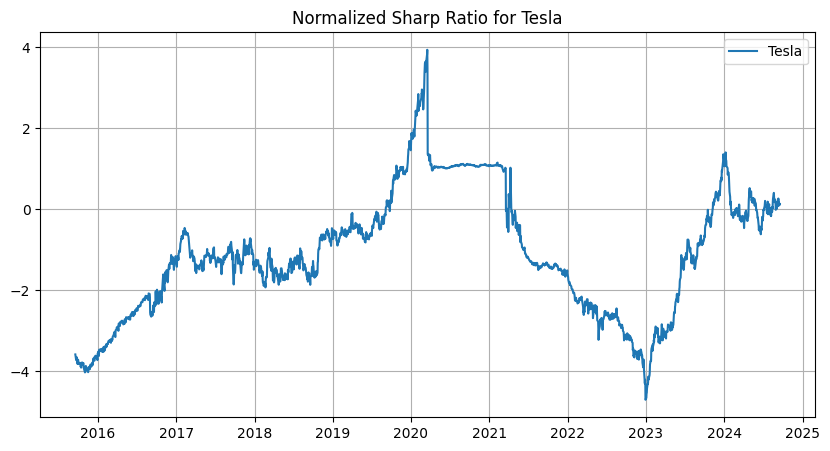

In [69]:
# plot normalzied sharp artio for tesla

tesla = yf.Ticker('TSLA')
tesla = tesla.history(period='10y')
tesla['Return'] = tesla['Close'].pct_change()
tesla['Datetime'] = tesla.index
tesla.reset_index(drop=True, inplace=True)
tesla['Date'] = tesla['Datetime'].dt.date
tesla['rf'] = rf['Close'].pct_change()
tesla['excess_return'] = tesla['Return'] - tesla['rf']
tesla['rolling_mean'] = tesla['excess_return'].rolling(window=WINDOW_SIZE).mean()
tesla['rolling_std'] = tesla['excess_return'].rolling(window=WINDOW_SIZE).std()
tesla['normalized_sharp_ratio'] = tesla['rolling_mean'] / tesla['rolling_std'] * (WINDOW_SIZE ** 0.5)

plt.figure(figsize=(10, 5))
plt.plot(tesla['Datetime'], tesla['normalized_sharp_ratio'], label='Tesla')
plt.title('Normalized Sharp Ratio for Tesla')
plt.legend()
plt.grid()
plt.show()
